# Deep Q-learning

#### Guillaume Berger

For the assignment of this week, I decided to play with **Deep Q-networks** i.e. Q-learning with approximation and the Q-value approximator is a **neural net**.

First, I read the *Atari* paper : **Mnih et al. (2015)** (https://arxiv.org/pdf/1312.5602.pdf) and I've also been through interesting blog posts on the subject: **Matiisen (2015)** https://www.nervanasys.com/demystifying-deep-reinforcement-learning/ and **Fiszel (2016)** https://rubenfiszel.github.io/posts/rl4j/2016-08-24-Reinforcement-Learning-and-DQN.html#prio. I think that these writings are good pointers for anyone who's interesting in trying to mix RL and DL for the first time.

Then, I started implementing Deep Q-networks and did some experiments on a toy example. Regarding the DL library, I'm using **Keras** v1 (https://keras.io/) with a **Theano** backend (but it should not be complicated to make this code work with a Tensorflow backend).

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle

### A Gridworld environment

As illustrated below, the tasks consists of **an agent evolving in a gridworld**. Here are the rules: 

- The *agent* (represented as a yellow cell with a black cross on it) starts at the up-left corner and needs to go accross the grid down to the *goal* at the down-right corner (represented as a grey cell). 
- For each move on a green cell, the reward is **-0.5**. 
- On the contrary, for each move on a purple cell, the reward is **+0.1**. 
- The reward for reaching the goal is **+1**.
- When the agent move on a purple cell, the cell turns to green.
- The positions of purple cells varies randomly from one episode to another.
- When the agent hits a border of the grid, he does not move.


With these rules, we expect the agent to learn to **find a path down to the goal which includes as many purple cells as possible**.

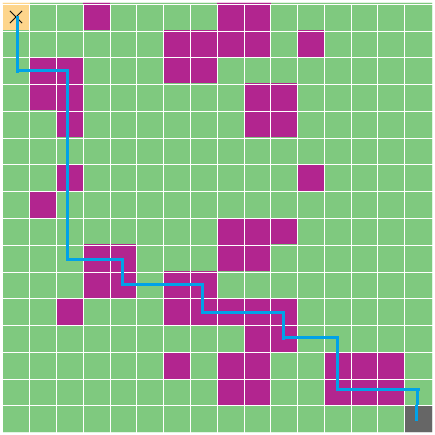

In [2]:
from IPython.display import Image
Image(filename='imgs/task.png') 

### Implementing the environment

The environment and its dynamics are impemented below. Nothing really fancy here. The code permits the specify the 
size of the grid (H, W), the minimum/maximum number of purple cells (Omin, Omax) and the min/max size of these purple zones (Smin, Smax).

In [3]:
class GridWorld:
    def __init__(self, H, W, Omin, Omax, Smin, Smax, 
                 background_value=0, agent_value=1, cheap_value=2, goal_value=3):
        self.H = H # height
        self.W = W # width
        self.Olim = [Omin, Omax] # min/max nb of obstacles
        self.Slim = [Smin, Smax] # min/max size of obstacles
        self.grid = np.zeros((H,W))
        self.agent_position = np.array([0, 0])
        self.goal_position = np.array([-1,-1])
        self.background_value = background_value
        self.agent_value = agent_value
        self.cheap_value = cheap_value
        self.goal_value = goal_value
        self.last_decision = "None"
        self.last_reward = None
        self.reset()
        
    def reset(self):
        # First add obstacles
        nzones = np.random.randint(self.Olim[0], self.Olim[1])
        for i in range(nzones):
            size = np.random.randint(self.Slim[0], self.Slim[1])
            self.add_cheap_zone(size)
        # Then add agents and goals
        self.agent_position = np.array([0, 0]) # up-left corner
        self.goal_position = np.array([self.H-1,self.W-1]) # down-right corner
        # Update the grid
        self.update_grid()
        
        
    def add_cheap_zone(self, size):
        pos = np.random.randint(0, (self.H-size)*(self.W-size))
        pos = np.array([int(pos//(self.H-size)), int(pos % (self.H-size))])
        self.grid[pos[0]:pos[0]+size, pos[1]:pos[1]+size] = self.cheap_value 
        
    def update_grid(self):
        '''Clear and update positions.'''
        self.grid[self.grid != self.cheap_value] = self.background_value
        # First, update the goal position
        h,w = self.goal_position
        self.grid[h,w] = self.goal_value
        # Then, update the runner position
        h,w = self.agent_position
        self.grid[h,w] = self.agent_value
        
    def clip_positions(self):
        '''Clip position to make sure objects are not outside the grid.'''
        for player in [self.goal_position, self.agent_position]:
            player[0] = np.clip(player[0], 0, self.H-1)
            player[1] = np.clip(player[1], 0, self.W-1)
        
    def update_from_decision(self, decision, verbose=False):
        '''Update the environment based on a decision'''
        possible_actions = ['left', 'right', 'up', 'down']
        if not type(decision) is str:
            if np.ndim(decision)==0:
                decision = possible_actions[decision]
            else: # one-hot
                decision = possible_actions[np.argmax(decision)]
        # Map 'string' action to 'numerical' ones
        if decision == 'left':
            u = [0, -1]
        elif decision == 'right':
            u = [0, +1]
        elif decision == 'down':
            u = [+1, 0]
        elif decision == "up":
            u = [-1, 0]
        # Update the position of the agent
        self.agent_position += u
        # Make sure that we did not get out the grid
        self.clip_positions()
        
        if self.is_terminal():
            R = +1.0
        elif self.grid[self.agent_position[0], self.agent_position[1]] == self.cheap_value:
            R = +0.1
        else:
            R = -0.5
        # Print (if asked)
        self.last_decision = decision
        self.last_reward = R
        if verbose:
            print "Decision: %s - Reward %.1f"%(decision, R)
        # Clear the grid
        self.update_grid()
        return R
        
    def return_state(self):
        return np.array(self.grid, "uint8")
        
    def is_terminal(self):
        return np.prod(self.goal_position == self.agent_position)==1
        
    def visualize(self, fig=True, figsize=(8,8)):
        '''Plot the current grid.'''
        if fig:
            plt.figure(figsize=figsize)
        plt.imshow(self.grid, interpolation="nearest", cmap=plt.get_cmap("Accent"))
        plt.scatter(self.agent_position[1], self.agent_position[0], marker="x", s=150, c="k")
        # White rows
        for i in range(self.H):
            plt.plot([-0.5, self.W+0.5], [i-0.5, i-0.5], c="w")
        # White columns
        for i in range(self.W):
            plt.plot([i-0.5, i-0.5], [-0.5, self.H+0.5], c="w")
        plt.title("Last decision: %s - Reward %s"%(self.last_decision, str(self.last_reward)))
        plt.axis('off')
        plt.ylim([self.H+0.5, -0.5])
        if fig:
            plt.show()

### Playing with the environment...

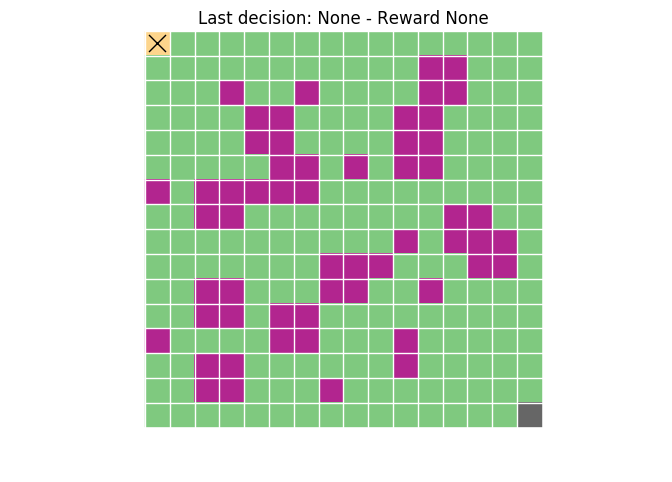

In [4]:
environment = GridWorld(16, 16, 20, 25, 1, 3)
environment.visualize()

### Simulating an episode manually

#### Starting a new episode

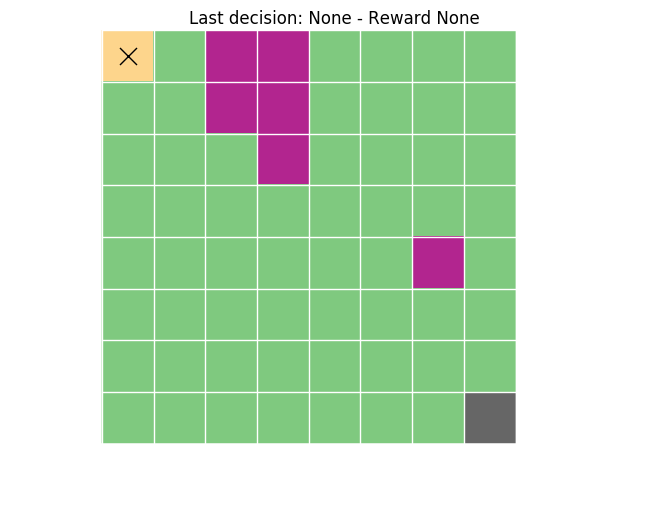

In [5]:
np.random.seed(123)
# New 8x8 environment
environment = GridWorld(8, 8, 1, 4, 1, 3)
environment.visualize()
i = 0
decisions = 3*["right"] + 4*["down"] + 3*["right"] + 3*["down"] + ["right"]

#### Press Ctrl + Enter to make the agent move...

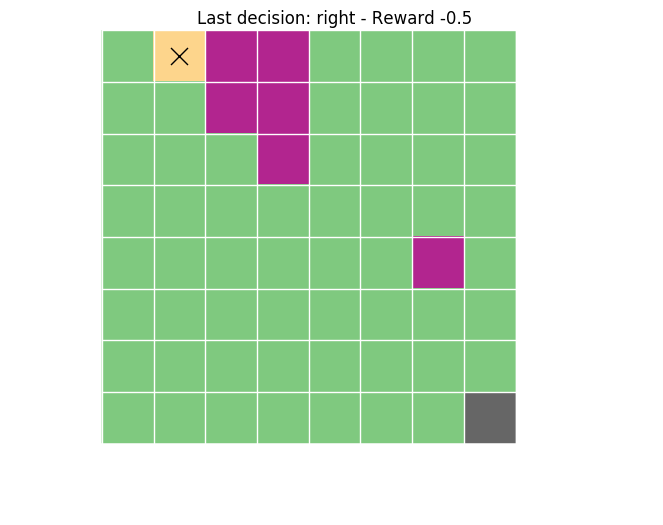

In [6]:
decision = decisions[i]
environment.update_from_decision(decision)
environment.visualize()
i += 1

## Utils functions

Nothing really important here, except maybe preprocessing functions which take the grid state and turn it into *float32* 3D arrays.

In [7]:
def one_hot(idx, length):
    """Turn an integer number (or a vector of int numbers), into 
    a one-hot vector (or a matrix whose rows are one-hot vectors)."""
    if np.ndim(idx) == 0:
        idx = np.array([idx])
    out = np.zeros((idx.shape[0], length), "float32")
    out[range(idx.shape[0]), idx] = 1
    return out

def preprocess_grid(grid):
    """Turn a 2D grid into a 3-channel image: one chanel for each kind
    of object (agent, obstacles, goal)"""
    # Add the batch axis & channel axis
    reshaped_grid = grid[None,None,:,:]
    # Stack and return as a 'float32' array
    return np.concatenate((reshaped_grid==1, reshaped_grid==2, reshaped_grid==3), axis=1).astype("float32")

def preprocess_grids(grids):
    """Same as 'preprocess_grid' but for several grids at the same time. 
    No need to add the batch axis."""
    # Add the channel axis
    reshaped_grids = grids[:, None, :, :]
    # Stack and return as a 'float32' array
    return np.concatenate((reshaped_grids==1, reshaped_grids==2, reshaped_grids==3), axis=1).astype("float32")
    
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## How to

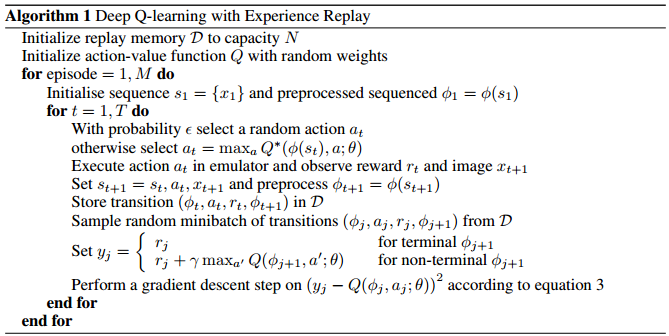

In [8]:
Image(filename='imgs/deep_qlearning.png') 

Algorithm presented in **Mnih et al 2015**

# RL code

The most important piece of code in the cell below is the *generator* called **offpolicy_qlearning_generator** :
this generator interacts with the environment, and yield batch of data to the deep net. Basically, this generator performs all steps described in the algorithm above, except the last one: *Perform a gradient step on ...*. This last step is taken care of by the keras function *fit_generator* (more on this later). 

Note also the **ExperienceReplay** class which permits to store interactions in a memory queue. During the training, the deep net is trained on batches containing the very last interaction but also oldest ones. This trick is important to stabilize the training process, and makes it faster. Here, we sample uniformly from the memory queue, which is not optimal. See this paper (https://arxiv.org/pdf/1511.05952.pdf) for fancier sampling techniques.

I also included the possibilty of using a **target network**. From what I read, this ingredient is another trick which helps stabilizing the training of DQN. Basically, when using this trick, the target is given by:

$$Y_t^{DQN} = R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a ; \theta^{-})$$

where $Q(S_{t+1}, a ; \theta^{-})$ is the approximation given by the target network, whose weights $\theta^{-}$ are set equals to $\theta$ every $C$ steps and are freezed otherwise. For more details on this, this paper (https://arxiv.org/pdf/1509.06461.pdf) is probably a good pointer.

In [9]:
def epsilon_greedy(q, epsilon):
    if np.random.rand()<epsilon:
        A = np.argmax(q)
    else:
        A = np.random.randint(0, q.shape[0])
    return A

def offpolicy_qlearning_generator(environment, experience_replay, net, B, target_net=None, gamma=0.95, 
                                  epsilon=0.8, C=10, nitermax=10000, test=False, nb_of_actions=4):
    """
    Inputs:
        - environment: a GridWorld instance
        - experience_replay: a ExperienceReplay instance
        - f : an Q-value approximator (i.e. the deep net)
        - B : batch size
    """
    global cum_rewards # expected to be a list
    
    if target_net is None:
        target_net = net
        update_target_net = False # no need to update the weights of the target net
    else:
        update_target_net = True
    
    # Repeat (for each episode):
    episode = 0
    update_count = 0
    start = time.time()
    while True:
        environment.reset() # New episode : reset the environment
        cum_reward = 0.
        episode_start = time.time()
        # Initial state and action of episode
        A = np.random.randint(0, nb_of_actions)
        S = environment.return_state()
        S_prep = preprocess_grid(S)
        # Repeat (for each step of episode)
        print "\rEpisode %d"%(episode),
        for it in range(nitermax):
            if it % 10 == 0:
                print "\rEpisode %d - Iteration %d"%(episode, it),
            # Take action A, observe R, S_prime
            R = environment.update_from_decision(A)
            S_prime = environment.return_state()
            # Store <A, S, Q, S'> in the memory
            experience_replay.store(S, A, R, S_prime, 1-int(environment.is_terminal()))
            
            ### Instead of using only <S,A,R,S'> to update theta, we will use
            ### a batch of interactions that have been previously experienced
            ### Ideally, it would be great to parallelize this code : 
            ###    - one generator which interacts with the environment and 
            ###      fills the memory queue
            ###    - one generator which reads the memory queue and yield batches 
            ###      to the neural net
            
            # Randomly pick interactions seen previously
            S_batch, A_batch, R_batch, S_prime_batch, T_batch = experience_replay.sample(B)
            # Preprocess states and get Q(S,:) 
            S_batch = preprocess_grids(S_batch)
            Q_batch = net.predict(S_batch)
            # Preprocess states and get Q(S',:) 
            S_prime_batch = preprocess_grids(S_prime_batch)
            Q_prime_batch = target_net.predict(S_prime_batch)
            # Build the target such that:
            #      - target[selected action] = R + gamma*max(Q(S',:))
            #      - target[other actions] = Q(S,:) (i.e. the loss is 0 for non-selected actions)
            A_batch_oh = one_hot(A_batch, nb_of_actions)
            target = (R_batch + gamma*T_batch*np.max(Q_prime_batch, axis=1))[:,None]*A_batch_oh + Q_batch*(1.-A_batch_oh)
            
            # Yield for SGD update
            yield S_batch, np.array(target, "float32")
            update_count += 1 # increment the update counter
            
            if update_count % C == 0 and update_target_net: # Update the weights of 'target_net'
                w = net.get_weights()
                target_net.set_weights(w)
            
            ### Back to the current episode
            cum_reward += (gamma**it)*R
            # If terminal:
            if environment.is_terminal():
                cum_rewards.append(cum_reward)
                break
            else:
                # Choose A' as a function of Q(S',*,theta)
                A_prime = epsilon_greedy(Q_prime_batch[0].flatten(), epsilon) # Assumes that the first row of 
                                                                              # the batch contains the last experienced
                                                                              # interaction
                # Update A, S, Q
                A = A_prime
                S = S_prime
        episode += 1
        
        
def exploitation_generator(environment, f, nb_of_actions=4):
    '''Call offpolicy_qlearning_generator with epsilon = 1. (exploitation)'''
    return offpolicy_qlearning_generator(environment, ExperienceReplay(environment.return_state().shape, 1),
                                                 f, B=1, epsilon=1.)

class ExperienceReplay():
    def __init__(self, state_shape, max_queue_size, dtype="uint8"):
        self.max_queue_size = max_queue_size
        # Initiate S and S' memories
        sh = tuple([max_queue_size] + list(state_shape))
        self.S_memory = np.zeros(sh, dtype=dtype)
        self.S_prime_memory = np.zeros(sh, dtype=dtype)
        # Action memory
        self.A_memory = np.zeros(max_queue_size, "uint8")
        # Reward memory
        self.R_memory = np.zeros(max_queue_size, "float32")
        # Terminal memory : 1 if terminal, 0 otherwise
        # We need to store this because the target is 
        # not the same whether the state is terminal or not
        self.T_memory = np.zeros(max_queue_size, "uint8")
        # Index of the next interaction to store
        self.idx = 0
        # Is the memory full ?
        self.full = False
        
    def store(self, S, A, R, S_prime, terminal):
        # Store <S, A, R, S'>
        self.S_memory[self.idx] = S
        self.A_memory[self.idx] = A
        self.R_memory[self.idx] = R
        self.S_prime_memory[self.idx] = S_prime
        self.T_memory[self.idx] = terminal
        # Increment self.idx
        self.idx += 1
        # Check if the memory is full
        if self.idx == self.max_queue_size:
            self.full = True
            self.idx = 0 # we will overwrite oldest interactions first
        
    def sample(self, B):
        # Return the last stored interaction + B-1 other interactions taken uniformly in the memory
        U = (1-int(self.full))*self.idx + int(self.full)*self.max_queue_size
        assert U > 0, "No interaction has been stored yet." 
        indices = [self.idx-1] + list(np.random.randint(0, U, B-1))
        return (self.S_memory[indices], self.A_memory[indices], self.R_memory[indices], 
                self.S_prime_memory[indices], self.T_memory[indices])

## DL code

In [10]:
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Flatten, Dense, merge
from keras.optimizers import SGD, Adam
import keras.backend as K

Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '13588' (I am process '2872')
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5105)


The next cells define 3 neural net architectures I tried (using Keras).

The first two architectures are designed to be used with a small 8x8 grid:
    
- **fc_linear** is in fact not really a deep net : no hidden layer, no non-linearity. The unique layer is fully connected to the input. With this network, we fall back in the context of **linear approximation**.

In [11]:
def fc_linear_8x8(grid_shape, lr=0.1):
    # Input node
    grid = Input(grid_shape)
    # Conv layer
    x = Convolution2D(4, 8, 8)(grid)
    q = Flatten()(x)
    # Keras model
    neuralnet = Model(grid, q)
    # Compile
    neuralnet.compile(SGD(lr=lr), loss="mse")
    return neuralnet

neuralnet = fc_linear_8x8((3,8,8))
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 8, 8)       0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 4, 1, 1)       772         input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 4)             0           convolution2d_1[0][0]            
Total params: 772
____________________________________________________________________________________________________


- **CNN_8x8** is a very simple neural net with only one hidden layer (with a ReLU non linearity):

In [12]:
def CNN_8x8(grid_shape, lr=0.1):
    # Input node
    grid = Input(grid_shape)
    # Hidden layer
    x = Convolution2D(16, 3, 3)(grid)
    x = Activation("relu")(x)
    # Output layer
    x = Convolution2D(4, 6, 6)(x)
    q = Flatten()(x)
    # Keras model
    neuralnet = Model(grid, q)
    # Compile
    #neuralnet.compile(Adam(lr=lr), loss="mse")
    neuralnet.compile(SGD(lr=lr), loss="mse")
    return neuralnet

neuralnet = CNN_8x8((3,8,8))
neuralnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 8, 8)       0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 16, 6, 6)      448         input_2[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 6, 6)      0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 4, 1, 1)       2308        activation_1[0][0]               
___________________________________________________________________________________________

Finally, **CNN_32x32** is deeper: 3 hidden layers with ReLU activations.

In [13]:
def CNN_32x32(grid_shape, lr=0.1):
    # Input node
    grid = Input(grid_shape)
    
    # Hidden layers
    x = Convolution2D(16, 3, 3, subsample=(2,2), border_mode="same")(grid)
    x = Activation("relu")(x)
    
    x = Convolution2D(32, 3, 3, subsample=(2,2), border_mode="same")(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(64, 3, 3)(x)
    x = Activation("relu")(x)
    
    # Output layer
    x = Convolution2D(4, 6, 6)(x)
    q = Flatten()(x)

    # Keras model
    neuralnet = Model(grid, q)
    # Compile
    neuralnet.compile(SGD(lr=lr), loss="mse")
    return neuralnet

neuralnet = CNN_32x32((3,32,32))
neuralnet.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 32, 32)     0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 16, 16, 16)    448         input_3[0][0]                    
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 16, 16, 16)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 8, 8)      4640        activation_2[0][0]               
___________________________________________________________________________________________

As you can see, the outputs of these deep nets are all of size 4. Indeed, as illustrated in the figure below, rather than having one approximator for each possible actions, it is simpler to have only on deep net able to predict $Q(S,a)$ for all $a$ in one forward pass.

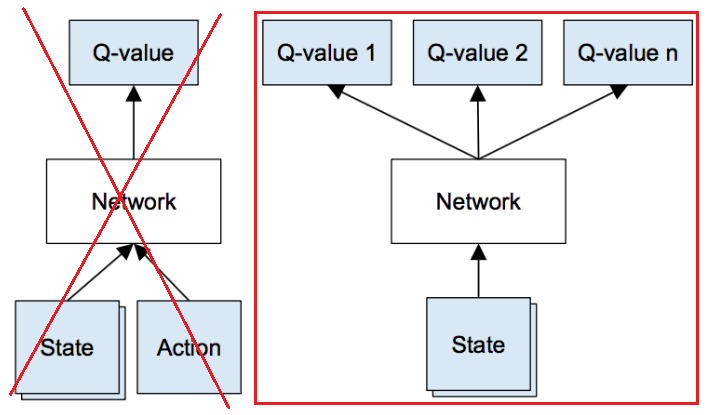

In [14]:
Image(filename='imgs/deep_q_nets.png') 

### Random moves with random weights

Just to check that everything works fine...

In [15]:
# Environment
environment = GridWorld(8, 8, 1, 4, 1, 3)
# A neural net
neuralnet = fc_linear_8x8((3, 8, 8), 0.01)
# ExperienceReplay 
experience_replay = ExperienceReplay(environment.return_state().shape, 1)
# A generator
epsilon = 0. # Fully stochastic
generator = offpolicy_qlearning_generator(environment, experience_replay, neuralnet, epsilon=epsilon, B=1)

#### Press Ctrl + Enter to make the agent move...

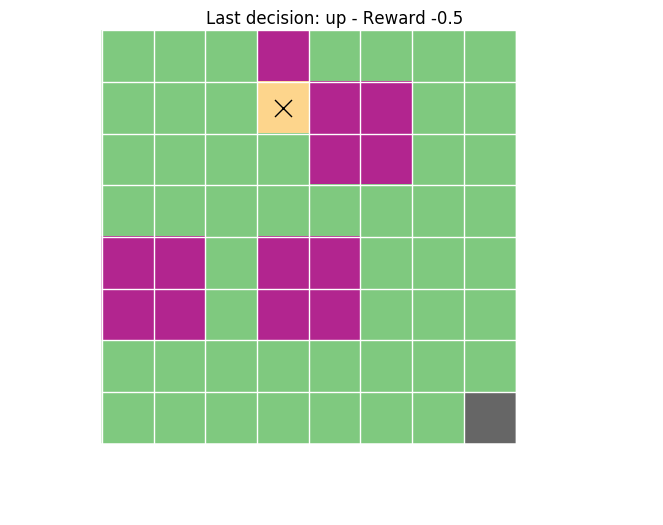

In [22]:
batch, target_batch = next(generator)
environment.visualize()

## First Experiment - 8x8 Grid - Linear approximation

I started small : 8x8 grid and linear approximation. 

As you can see, the SGD part of the algorithm showed previously is taken care of by the line *neuralney.fit_generator(generator...)*.

The code below permits to lauch 4 concecutive trainings, using or not experience replay and target network tricks.
See the results below...

In [ ]:
# Fixed params
epsilon = 0.75
LR = 0.1
gamma = 0.95
# Varying params
batch_sizes = [1, 1, 128, 128]
max_queue_sizes = [1, 1, 20000, 20000]
use_a_target_net = [False, True, False, True]
Cs = [1, 10, 1, 10]
names = ["no_replay_no_target_net", "no_replay", "no_target_net", "replay_and_target_net"]

results = dict()

for B, m, t, C, name in zip(batch_sizes, max_queue_sizes, use_a_target_net, Cs, names):
    # Fix the seed
    np.random.seed(123)
    # Define the environment
    environment = GridWorld(8, 8, 1, 4, 1, 3)
    # Get deep nets
    neuralnet = fc_linear((3, 8, 8), LR)
    if t:
        target_net = fc_linear((3, 8, 8), LR)
    else:
        target_net = None
    # Where to store cumulative rewards
    cum_rewards = []
    # Experience replay
    experience_replay = ExperienceReplay(environment.return_state().shape, m)
    # Generator
    generator = offpolicy_qlearning_generator(environment, experience_replay, neuralnet, 
                                              target_net=target_net, B=B, epsilon=epsilon, C=C, 
                                              gamma=gamma)
    # Training
    print("\nTraining : %s"%name)
    start = time.time()
    h = neuralnet.fit_generator(generator, 500*B, nb_epoch=150, verbose=0) # 150 epoch of 500 updates
    end = time.time()
    print("\nTook %.1fs."%(end-start))
    # Save results
    results[name] = [cum_rewards[:], h.history['loss']]
    # Save weights
    neuralnet.save_weights("experiment_01/%s.weights"%name)

#### Saving results

In [23]:
#with open("experiment_01/results.pkl", "w") as f:
#    pickle.dump(results, f)

#with open("experiment_01/results.pkl", "r") as f:
#    results = pickle.load(f)

*Note: the results.pkl file, as well as weights are provided. You can load these if you want to.*

During the training I kept track of the cumulative rewards after every episode for each setting:

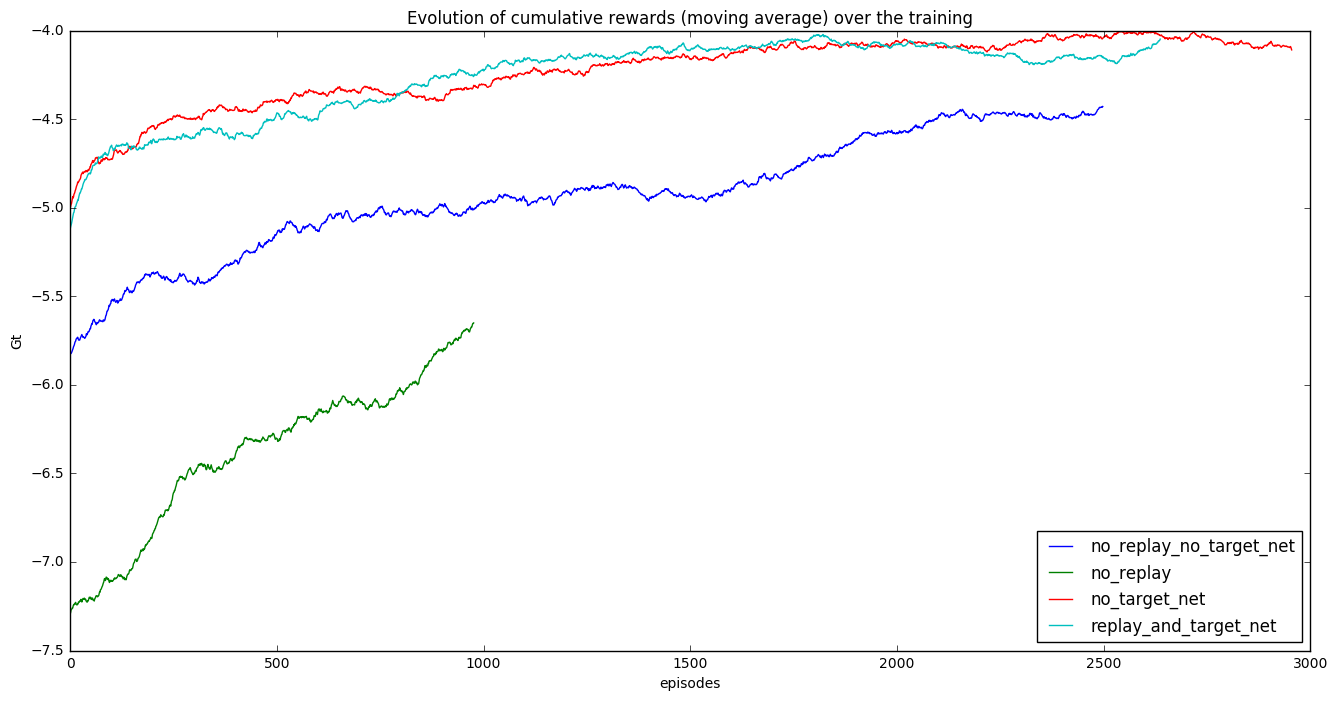

In [46]:
names = ["no_replay_no_target_net", "no_replay", "no_target_net", "replay_and_target_net"]
cum_rewards = []

plt.figure(figsize=(16,8))
for name in names:
    plt.plot(moving_average(results[name][0], 500), label=name)
plt.legend(loc=4)
plt.title("Evolution of cumulative rewards (moving average) over the training")
plt.ylabel("Gt")
plt.xlabel("episodes")
plt.show()

As you can see, **experience replay** helps a lot. Regarding the use of a target network, on this task, it does not seem to make a big difference.

### Ok... but how does it really perform ?

Let's  play with our trained approximator

In [25]:
neuralnet.load_weights("experiment_01/replay_and_target_net.weights")

In [26]:
exploitation_gen = exploitation_generator(environment, neuralnet)

#### Press Ctr + Enter to make it move...

Episode 1 - Iteration 0

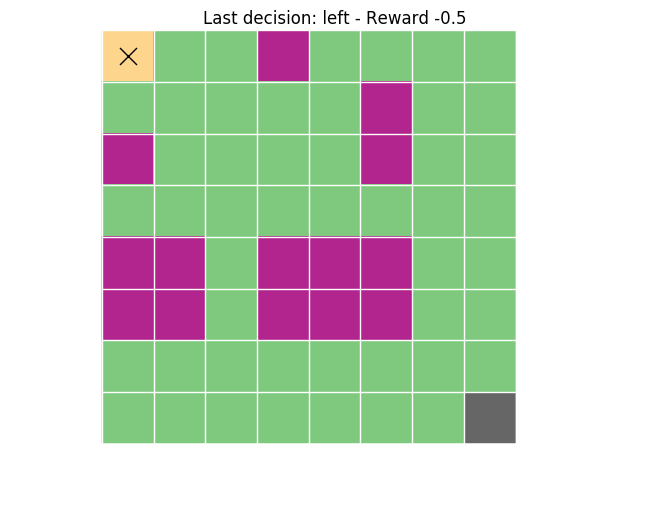

In [42]:
batch, target_batch = next(exploitation_gen)
environment.visualize()

If you managed to execute the last cell, you'll  see that the agent always goes directly to the goal (as expected), but most of the time, it misses the purple cells... This is probably due to the fact that our approximator is extremely simple for this experiment: the approximator fails to adapt its outputs with respect to the position of purple cells.

## Second experiment - 8x8 grid - Adding a non-linearity

What's the point of being able to train deep nets if we don't use non-linearities ? Let's add a ReLU somewhere...

In [45]:
epsilon = 0.75
LR = 0.1
gamma = 0.95
B = 128
m = 20000
t =  True
C = 10
name = "replay_and_target_net"

results2 = dict()

# Fix the seed
np.random.seed(123)
# Define the environment
environment = GridWorld(8, 8, 1, 4, 1, 3)
# Get deep nets
neuralnet = CNN_8x8((3, 8, 8), LR)
if t:
    target_net = CNN_8x8((3, 8, 8), LR)
else:
    target_net = None
# Where to store cumulative rewards
cum_rewards = []
# Experience replay
experience_replay = ExperienceReplay(environment.return_state().shape, m)
# Generator
generator = offpolicy_qlearning_generator(environment, experience_replay, neuralnet, 
                                          target_net=target_net, B=B, epsilon=epsilon, C=C, 
                                          gamma=gamma)
# Training
print("\nTraining : %s"%name)
start = time.time()
h = neuralnet.fit_generator(generator, 500*B, nb_epoch=150, verbose=0)
end = time.time()
print("\nTook %.1fs."%(end-start))
# Save results
results2[name] = [cum_rewards[:], h.history['loss']]
# Save weights
neuralnet.save_weights("experiment_02/%s.weights"%name)


Training : replay_and_target_net
Episode 3633 - Iteration 0 
Took 642.8s.


#### Saving results

In [47]:
#with open("experiment_02/results.pkl", "w") as f:
#    pickle.dump(results2, f)

#with open("experiment_02/results.pkl", "r") as f:
#    results2 = pickle.load(f)

As you can see on the figure below, adding a non-linearity is benefic:

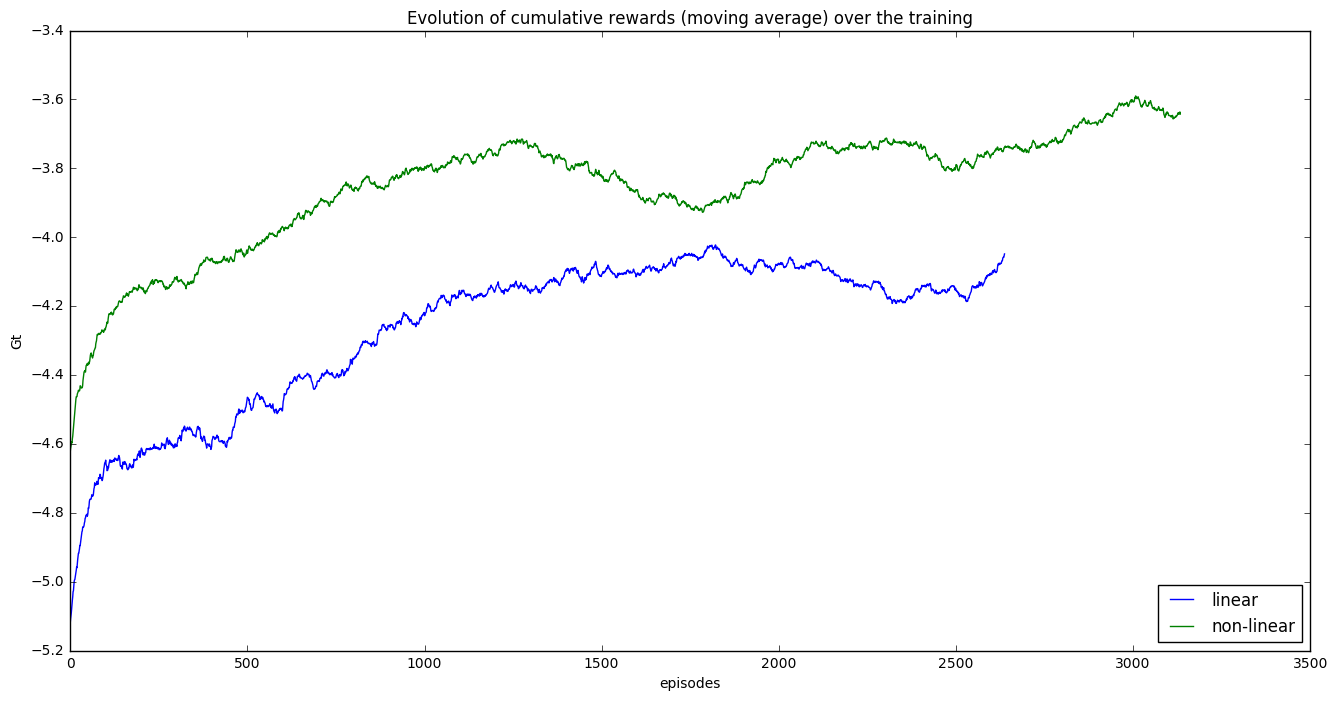

In [48]:
name = "replay_and_target_net"
cum_rewards = []

plt.figure(figsize=(16,8))
plt.plot(moving_average(results[name][0], 500), label="linear")
plt.plot(moving_average(results2[name][0], 500), label="non-linear")
plt.legend(loc=4)
plt.title("Evolution of cumulative rewards (moving average) over the training")
plt.ylabel("Gt")
plt.xlabel("episodes")
plt.show()

#### Playing with our non-linear approximator...

In [49]:
neuralnet.load_weights("experiment_02/replay_and_target_net.weights")
exploitation_gen = exploitation_generator(environment, neuralnet)

Episode 5 - Iteration 0

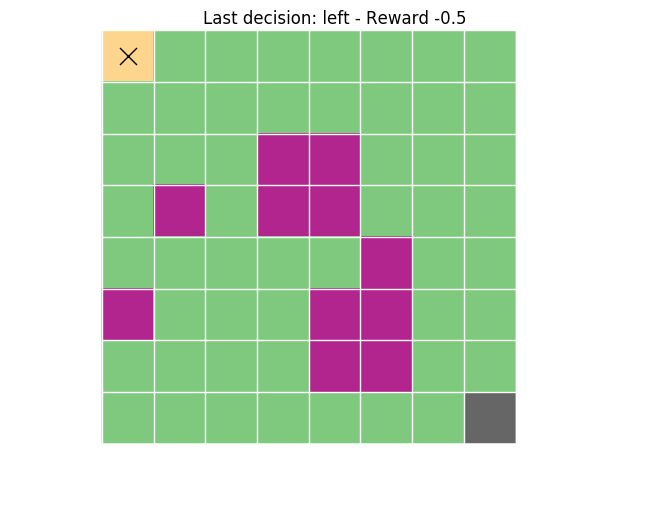

In [124]:
batch, target_batch = next(exploitation_gen)
environment.visualize()

Playing with our non-linear approximator confirms that the agent makes now clever moves. It is not perfect, but it misses purple cells less often.

I did not have time to do a lot of experiments: it should be easy to improve these results by trying other architectures, tuning hyperparameters...

I wanted to do more experiments. In particular, I wanted to try increasing the size of the grid: in the Atari paper, the dimension of the grid is 84x84... I started trying to train a deep net on a 32x32 grid (using the *CNN_32x32* architecture) but I've not managed to obtain any decent results yet. I might continue working on this notebook within the next few days...

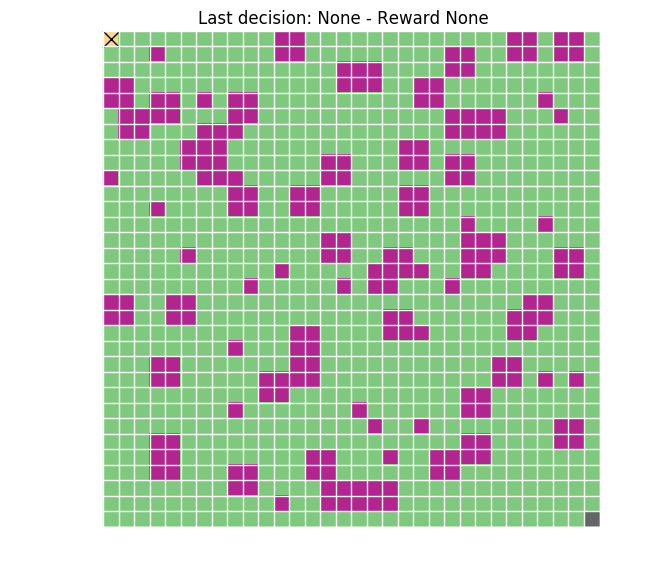

In [135]:
environment = GridWorld(32, 32, 80, 100, 1, 3)
environment.visualize()

In [138]:
epsilon = 0.75
LR = 0.1
gamma = 0.95
B = 128
m = 20000
t =  True
C = 10
name = "replay_and_target_net"

results3 = dict()

# Fix the seed
np.random.seed(123)
# Define the environment
environment = GridWorld(32, 32, 80, 100, 1, 3)
# Get deep nets
neuralnet = CNN_32x32((3, 32, 32), LR)
if t:
    target_net = CNN_32x32((3, 32, 32), LR)
else:
    target_net = None
# Where to store cumulative rewards
cum_rewards = []
# Experience replay
experience_replay = ExperienceReplay(environment.return_state().shape, m)
# Generator
generator = offpolicy_qlearning_generator(environment, experience_replay, neuralnet, 
                                          target_net=target_net, B=B, epsilon=epsilon, C=C, 
                                          gamma=gamma)
# Training
print("\nTraining : %s"%name)
start = time.time()
h = neuralnet.fit_generator(generator, 500*B, nb_epoch=10000, verbose=0)
end = time.time()
print("\nTook %.1fs."%(end-start))
# Save results
results3[name] = [cum_rewards[:], h.history['loss']]
# Save weights
neuralnet.save_weights("experiment_03/%s.weights"%name)

 
Training : replay_and_target_net
Episode 256 - Iteration 310

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in multiply


Episode 331 - Iteration 9460

KeyboardInterrupt: 